# Absorption modeling

In [1]:
import spekpy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# Set figure parameters
fig_width = 3.25 #ECS spec is 3.25" width
fig_width_2col_inches = 7
fig_height = (3/4)*fig_width # standard ratio

rcParams['figure.autolayout'] = True
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 8
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 8
rcParams['xtick.bottom'] = False
rcParams['ytick.direction'] = 'in' 

1091109051.9489682


Text(0, 0.5, 'Fluence')

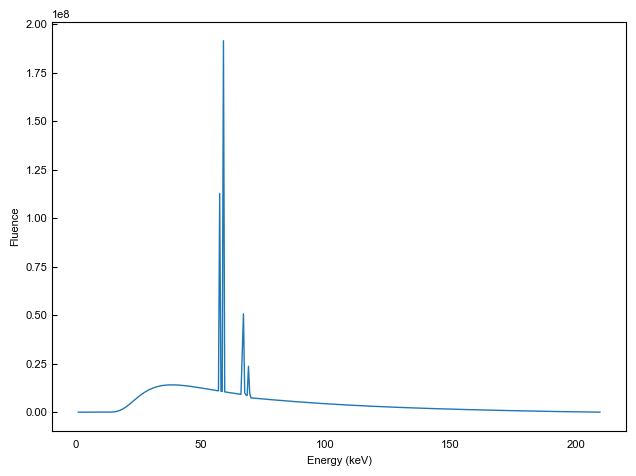

In [3]:
s = sp.Spek(kvp=210,th=40) # Generate a spectrum (210 kV, 40 degree tube angle)
s.filter('Al', 2.5) # Filter by 2.5 mm of Al
fluence_original = s.get_flu()
print(fluence_original)

kbins_original, spectrum_original = s.get_spectrum()
plt.plot(kbins_original, spectrum_original)
plt.xlabel('Energy (keV)')
plt.ylabel('Fluence')

Make a material for the cathode (LiNi0.8Mn0.1Co0.1O2):

In [4]:
name = 'NMC811'
comment = 'Defined by chemical formula'
composition='LiNi0.8Mn0.1Co0.1O2'
density = 2.2 # g/cm3
sp.Spek.make_matl(matl_name=name, matl_density=density, chemical_formula=composition, matl_comment=comment)

Now, create a list with the composition and thicknesses of the battery components in order.

We model the unit stack of the battery as:
- A cathode with a single-sided thickness of 60 um and porosity of 50% (effective thickness = 30 um)
- An Al current collector with a single-sided thickness of 10 um
- A cathode with a single-sided thickness of 60 um and porosity of 50% (effective thickness = 30 um)
- An anode with a single-sided thickness of 80 um and porosity of 50% (effective thickness = 40 um)
- A Cu current collector with a single-sided thickness of 10 um
- An anode with a single-sided thickness of 80 um and porosity of 50% (effective thickness = 40 um)

We model the battery as:
- A can with a thickness of 0.2 mm
- The unit stack of the battery * 40
- A can with a thickness of 0.2 mm

All of these values are estimated via the Glimpse Portal.

In [5]:
electrode_stack = [("NMC811", 0.06 * 0.5), ("Al", 0.01), ("NMC811", 0.06 * 0.5), ("C", 0.08 * 0.5), ("Cu", 0.01), ("C", 0.08 * 0.5)]
electrode_stacks = electrode_stack * 40
battery_components = [("Fe", 0.2)] + electrode_stacks + [("Fe", 0.2)]

print(battery_components)
print(len(battery_components))

[('Fe', 0.2), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.04), ('NMC811', 0.03), ('Al', 0.01), ('NMC811', 0.03), ('C', 0.04), ('Cu', 0.01), ('C', 0.0

Go through all components and filter:

In [6]:
absorption_dict = {
    "Fe": 0,
    "NMC811": 0,
    "Al": 0,
    "C": 0,
    "Cu": 0
}

for component in battery_components:
    current_fluence = s.get_flu()
    s.filter(component[0], component[1])
    new_fluence = s.get_flu()
    absorption_dict[component[0]] += current_fluence - new_fluence

print(absorption_dict)

{'Fe': 311737708.91630757, 'NMC811': 206421763.11677527, 'Al': 13435920.504461348, 'C': 44474162.26979774, 'Cu': 227752327.95948076}


Calculate the percent absorption for each component:

In [7]:
# Calculate the sum of all values
total_sum = sum(absorption_dict.values())

# Normalize each value
absorption_dict_normalized = {key: 100 * value / total_sum for key, value in absorption_dict.items()}
print(absorption_dict_normalized)

{'Fe': 38.78193858610568, 'NMC811': 25.68003777233013, 'Al': 1.6715046943252871, 'C': 5.532837961155515, 'Cu': 28.333680986083387}


Perform some final calculations:

In [8]:
fluence_final = s.get_flu()
absorbed_percent = 100 * (1 - fluence_final / fluence_original)

kbins_final, spectrum_final = s.get_spectrum()

Sanity check:

In [9]:
total_sum + fluence_final - fluence_original

0.0

Visualize:

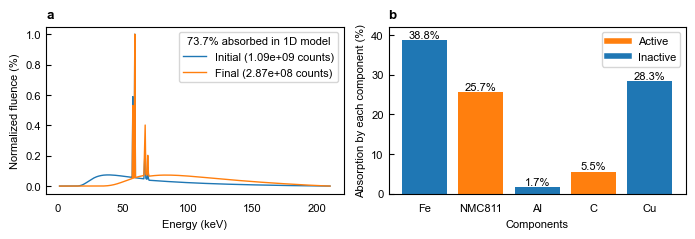

In [10]:
fig, ax = plt.subplots(figsize=(fig_width_2col_inches, fig_height), ncols=2, nrows=1)
ax[0].plot(kbins_original, spectrum_original / spectrum_original.max(), label=f'Initial ({fluence_original:.3g} counts)')
ax[0].plot(kbins_final, spectrum_final / spectrum_final.max(), label=f'Final ({fluence_final:.3g} counts)')
ax[0].set_xlabel('Energy (keV)')
ax[0].set_ylabel('Normalized fluence (%)')
ax[0].set_title('a', loc='left', weight='bold')
ax[0].legend(title=f'{absorbed_percent:.1f}% absorbed in 1D model')


colors = ['tab:orange' if key in ['NMC811', 'C'] else 'tab:blue' for key in absorption_dict_normalized.keys()]
bars = ax[1].bar(absorption_dict_normalized.keys(), absorption_dict_normalized.values(), color=colors)
ax[1].set_xlabel('Components')
ax[1].set_ylabel('Absorption by each component (%)')
ax[1].set_title('b', loc='left', weight='bold')
active_patch = plt.Line2D([0], [0], color='tab:orange', lw=4, label='Active')
inactive_patch = plt.Line2D([0], [0], color='tab:blue', lw=4, label='Inactive')
ax[1].legend(handles=[active_patch, inactive_patch])
# Add percentages at the top of each bar
for bar, value in zip(bars, absorption_dict_normalized.values()):
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value:.1f}%', ha='center', va='bottom')
ax[1].set_ylim(0, 42.1)

plt.tight_layout()
plt.savefig('absorption_example.pdf', bbox_inches='tight')